# Team 4 Machine Predictive Maintenance Classification

Contributors: Elan Wilkinson, Zack Robertson, Alden Caterio, Laxmi Sulakshana Rapolu


## Problem Statement and Justification

Companies that produce various types of machinery are aware that all of their products have a breaking point, and they are highly interested in understanding the causes. Having a clear understanding of why a machine breaks can be helpful in multiple ways. The company can create more robust machines which are less prone to failure, develop methods to maintain existing machines, and even predict when a machine may fail, extending its lifespan and saving the customer money and resources.

In this project, we examine a Predictive Maintenance Dataset which comprises of temperature readings, readings from and measurement data from the equipment, product quality variants, failure states, and failure types. Using the dataset, we will predict likely future failure and type. Multiple modeling approaches will be evaluated, with a particular emphasis on leveraging ensemble methods.

## Dataset
The Predictive Maintenance Dataset encompasses 10,000 data points, each with 10 distinct features. These features include a unique identifier (UID), product ID with quality variants (L, M, H), air temperature [K], process temperature [K], rotational speed [rpm], torque [Nm], tool wear [min], and a ‘machine failure’ label indicating the occurrence of a failure.
The dataset also includes multiple failure modes: Power Failure, Tool Wear Failure, Overstrain Failure, Random Failures, and Heat Dissipation Failure.

Dataset URL: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.activations import relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Clean up warnings and loggings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.INFO)

In [29]:
machining_failure_data = pd.read_csv('predictive_maintenance.csv')

## Exploratory Data Analysis

Conducting exploratory data analysis, we can familiarize ourselves with the dataset and identify any errors or anomalies within the data.

In [30]:
print('First 5 rows of the dataset:')
machining_failure_data.head()

First 5 rows of the dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [109]:
print(machining_failure_data.describe())

               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25

In [110]:
print("Missing Value Counts:")
print(machining_failure_data.isnull().sum())

Missing Value Counts:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [31]:
# These are the Dependent Variables
failure_status = machining_failure_data['Target']
failure_types = machining_failure_data['Failure Type']

# Unique ID variables
id_cols = ['UDI','Product ID']

# IV = Independent Variables
machining_failure_IVs = machining_failure_data.copy()
machining_failure_IVs = machining_failure_IVs.drop(id_cols, axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Target', axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Failure Type', axis=1)

In [ ]:
# print failure_types unique vals
print(f"Unique failure types found in the dataset:\n{failure_types.unique()}")

Unique failure types found in the dataset:
['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [32]:
# Make Type Column Ordinal
machining_failure_data['Type'] = machining_failure_data['Type'].map({'L':0, 'M':1, 'H':2})
machining_failure_IVs['Type'] = machining_failure_IVs['Type'].map({'L':0, 'M':1, 'H':2})

Correlation Matrix:


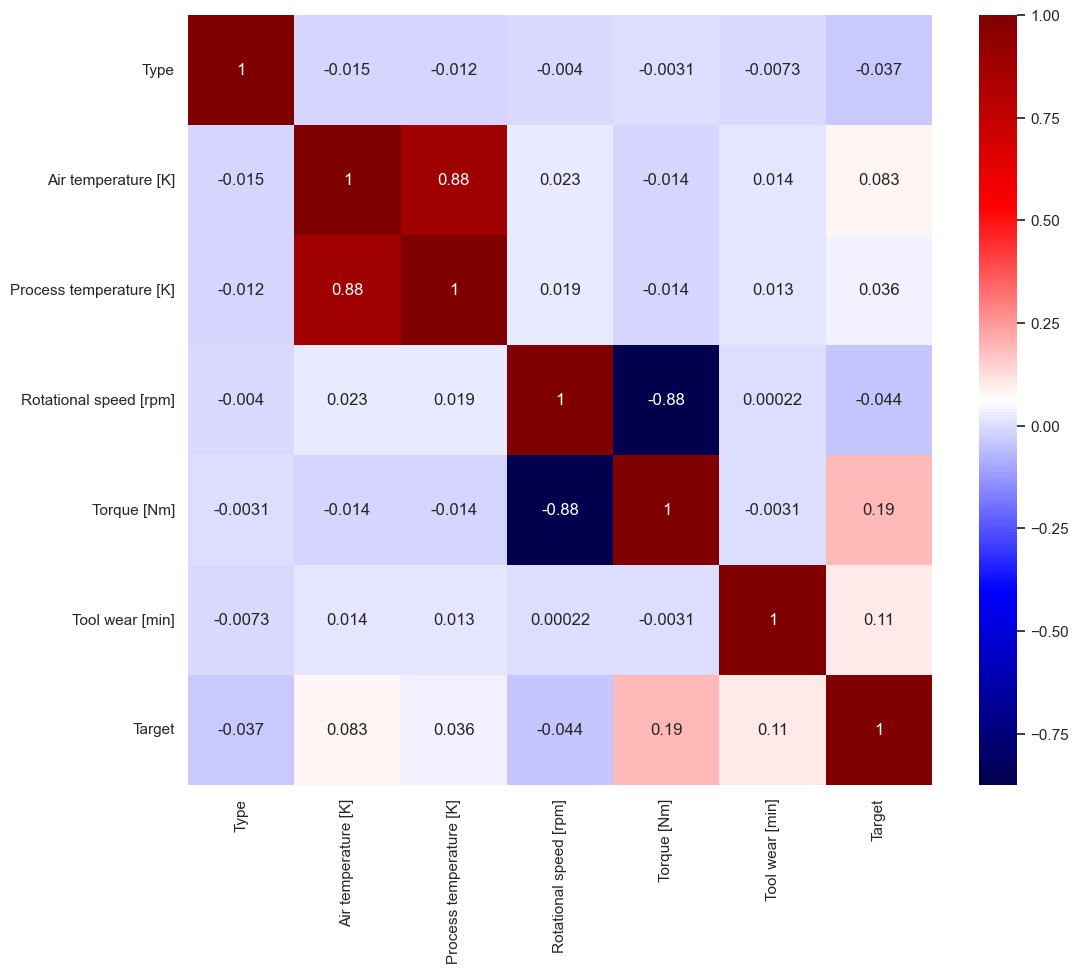

In [88]:
print("Correlation Matrix:")
machining_failure_corrmat = machining_failure_data.copy()
machining_failure_corrmat.drop(id_cols, axis=1, inplace=True)
machining_failure_corrmat.drop('Failure Type', axis=1, inplace=True)

plt.figure(figsize=(12,10))

cor = machining_failure_corrmat.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.seismic)
plt.show()


In [13]:
machining_failure_IVs.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,298.1,308.6,1551,42.8,0
1,0,298.2,308.7,1408,46.3,3
2,0,298.1,308.5,1498,49.4,5
3,0,298.2,308.6,1433,39.5,7
4,0,298.2,308.7,1408,40.0,9


Comparative Box Plots For Each Feature:


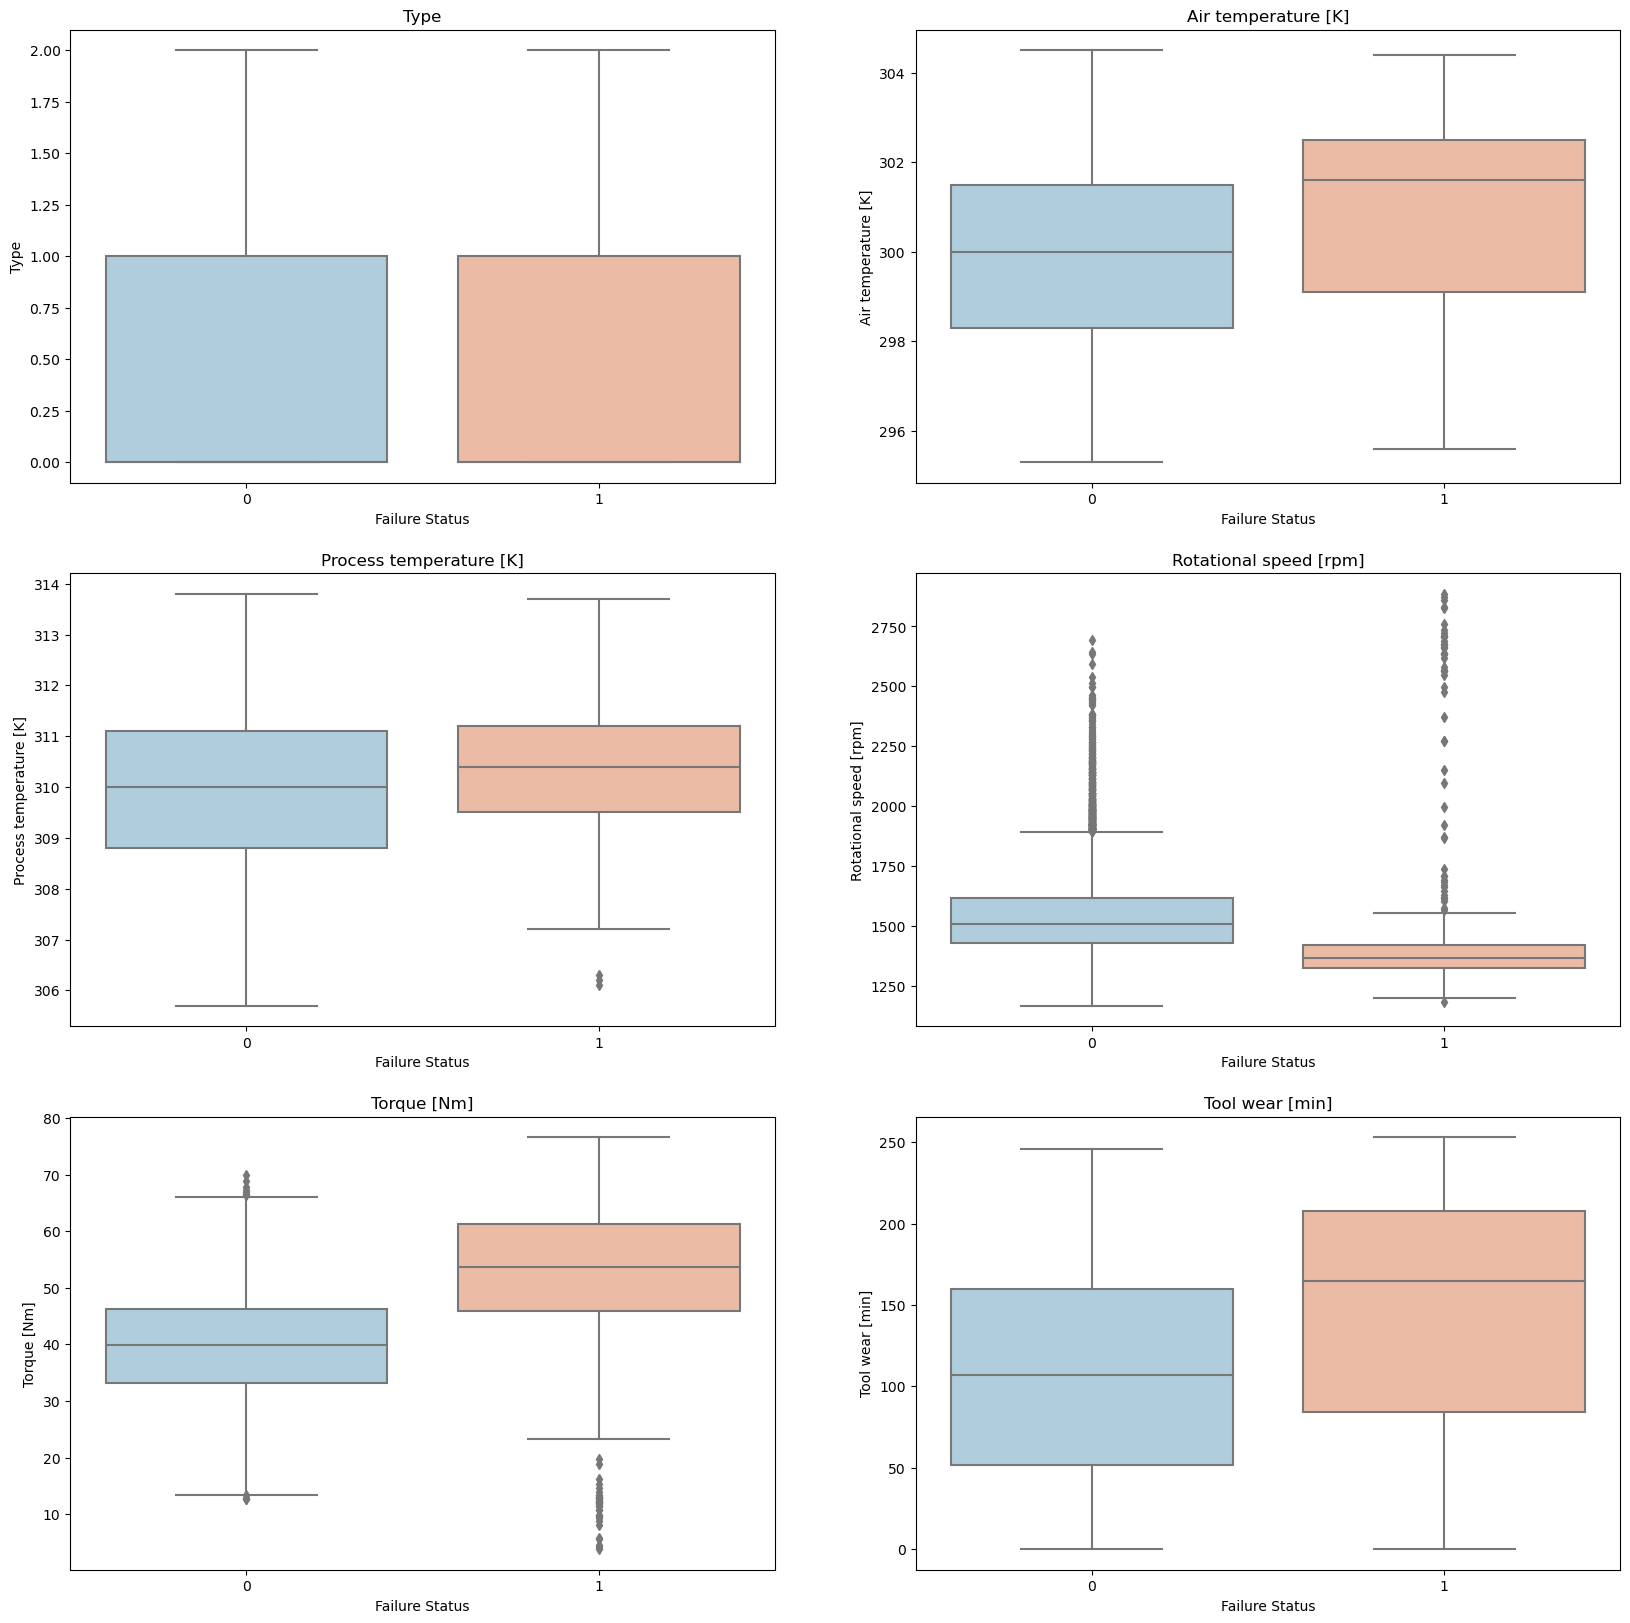

In [14]:
print("Comparative Box Plots For Each Feature:")
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
for i, col in enumerate(machining_failure_IVs.columns):
    sns.boxplot(x=failure_status, y=col, data=machining_failure_IVs, ax=axes[i//2, i%2], palette='RdBu_r')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Failure Status')


Bar Chart of Failure Types:


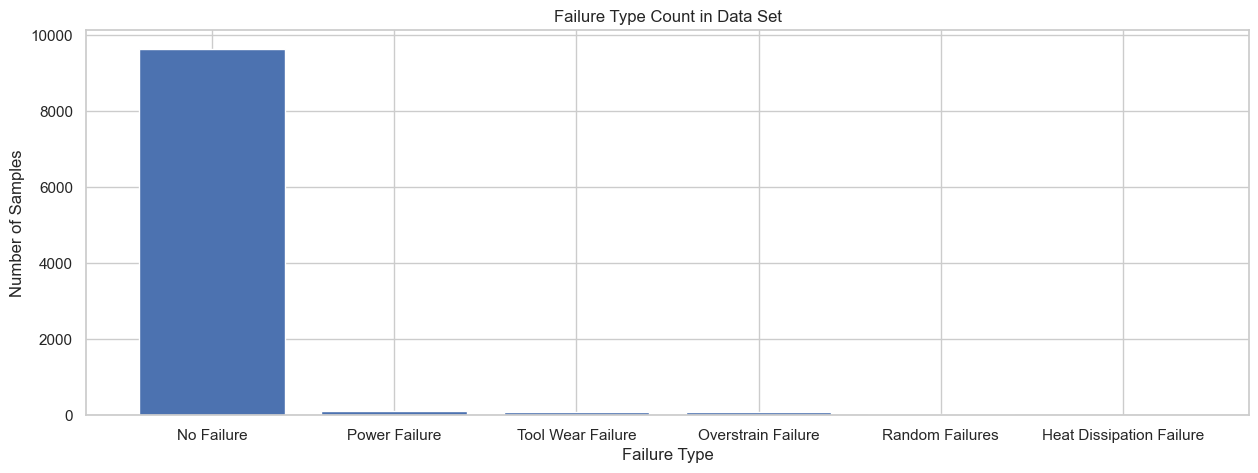

In [25]:
# Create Chart of Failure Type Counts to Visualize Data Imbalance
print("Bar Chart of Failure Types:")
plt.figure(figsize=(15, 5))
plt.bar(failure_types.unique(), failure_types.value_counts())
plt.xlabel('Failure Type')
plt.ylabel('Number of Samples')
plt.title('Failure Type Count in Data Set')
plt.show()

### Plotting Features Over Time


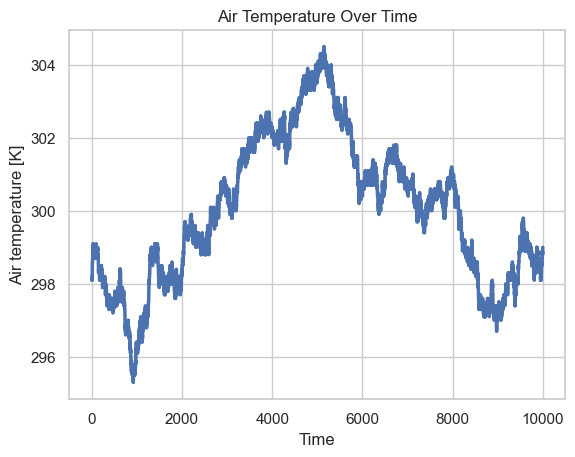

In [17]:
# Plot Room Temperature over Time
sns.set(style="whitegrid")
sns.lineplot(machining_failure_data["Air temperature [K]"], palette='tab10', linewidth=2.5)
plt.xlabel('Time')
plt.title('Air Temperature Over Time')
plt.show()


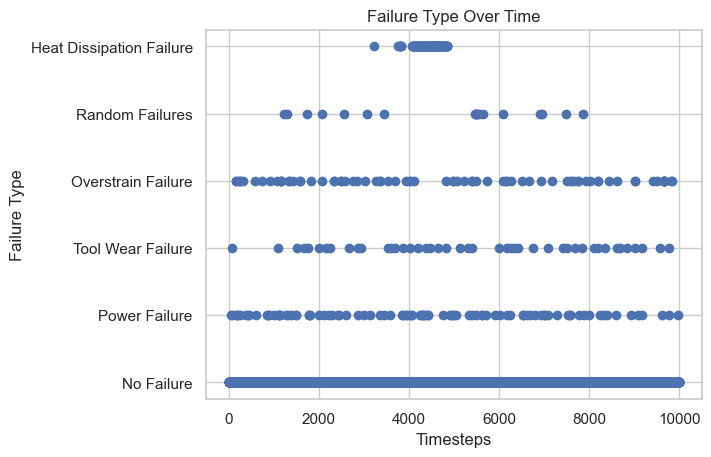

In [21]:
# Plot of the types of failures over time
plt.scatter(machining_failure_data['UDI'],machining_failure_data['Failure Type'])
plt.xlabel('Timesteps')
plt.ylabel('Failure Type')
plt.title('Failure Type Over Time')
plt.show()


## Data Preparation

### Feature Engineering

Feature engineering is the process of creating new features from existing features to enhance our understanding of the dataset and possibly improve training and testing.

To train our model, the dataset must be split into a training set and a testing set.

One of the features of the dataset is "Product ID". Product ID is a unique identifier for each entry. If the number of unique Product IDs is less than the total number of entries in the dataset, then there must be multiple entries of the same Product ID. If the number of unique Product IDs is equal to the total number of entries, then all the entries are unique.

In [ ]:
# Find total number of entries
print(f"Shape of dataset: {np.shape(machining_failure_data)}")

Shape of dataset: (10000, 10)


In [33]:
# Find total number of unique entries in "Product ID"
num_unique_prodIDs = len(machining_failure_data['Product ID'].unique());
print(f"Number of unique product IDs = {num_unique_prodIDs}")

Number of unique product IDs = 10000


From the code above, we find that the dataset contains 10000 entries as well as 10000 unique Product IDs. Since they are equal, all entries are unique.

We are interested not only in the ability to detect current failure, but in predicting an upcoming failure before it occurs. An interval of 5 time steps preceding failure will be set as the threshold for pre-failure.

In [34]:
# Addition of Pre-Failure States
prefailure = 0
prefailure_type = ''

# Iterate backwards through the machining_failure_data, set the failure state to rows preceding failure to prefailure-{Failure Type}
for index, row in machining_failure_data[::-1].iterrows():
    if prefailure == 0 and row['Failure Type'] != "No Failure":
        prefailure = 5
        prefailure_type = 'prefailure' + '-' + row['Failure Type']
    elif prefailure > 0:
        machining_failure_data.loc[index,'Failure Type'] = prefailure_type
        prefailure = prefailure - 1

### Feature Selection

Here are the features that will be used as the dependent variables and independent variables. The independent variables will be used to predict the dependent variables.

In [35]:
# The dependent variables
failure_status = machining_failure_data['Target']
failure_types = machining_failure_data['Failure Type']

# The independent variables
machining_failure_IVs = machining_failure_data
machining_failure_IVs = machining_failure_IVs.drop(id_cols, axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Target', axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Failure Type', axis=1)

### Creation of Train-Test Split

In [36]:
# Creation of Train Test Split
train_x, test_x, train_y, test_y = train_test_split(machining_failure_IVs, failure_status, test_size=0.4, random_state=32, shuffle=True)

### Addressing Data Imbalance

In [37]:
undersampler = RandomUnderSampler(random_state = 32, replacement=False, sampling_strategy=0.4)
oversampler = RandomOverSampler(random_state = 32, sampling_strategy=0.6)

x_under,y_under = undersampler.fit_resample(train_x, train_y)
x_over, y_over = oversampler.fit_resample(x_under,y_under)

## Modeling - Failure Prediction

### Modeling of Prediction of Current Failure or No Current Failure

In [38]:
# Conversion of machining_failure_data to a tensor for use by LSTM model
machining_failure_data_nparray = x_over.values
machining_failure_data_tensor = tf.convert_to_tensor(machining_failure_data_nparray, dtype=tf.float32)

# Creation of LSTM Model
lstm_model = Sequential([
    Dense(32, input_dim=6),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])

# Compile the model
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the model
lstm_history = lstm_model.fit(machining_failure_data_tensor, y_over, epochs=100, batch_size=32)

Epoch 1/100
27/27 [==============================] - 0s 937us/step - loss: 61.2685 - accuracy: 0.3960
Epoch 2/100
27/27 [==============================] - 0s 751us/step - loss: 13.5919 - accuracy: 0.4736
Epoch 3/100
27/27 [==============================] - 0s 805us/step - loss: 8.1709 - accuracy: 0.4524
Epoch 4/100
27/27 [==============================] - 0s 809us/step - loss: 5.6594 - accuracy: 0.4254
Epoch 5/100
27/27 [==============================] - 0s 895us/step - loss: 2.9035 - accuracy: 0.4536
Epoch 6/100
27/27 [==============================] - 0s 899us/step - loss: 1.2580 - accuracy: 0.5934
Epoch 7/100
27/27 [==============================] - 0s 918us/step - loss: 0.6321 - accuracy: 0.7391
Epoch 8/100
27/27 [==============================] - 0s 785us/step - loss: 0.5057 - accuracy: 0.7732
Epoch 9/100
27/27 [==============================] - 0s 918us/step - loss: 0.4625 - accuracy: 0.7885
Epoch 10/100
27/27 [==============================] - 0s 862us/step - loss: 0.4479 - accu

### Visualize the Model Accuracy and Loss over the Epochs

dict_keys(['loss', 'accuracy'])


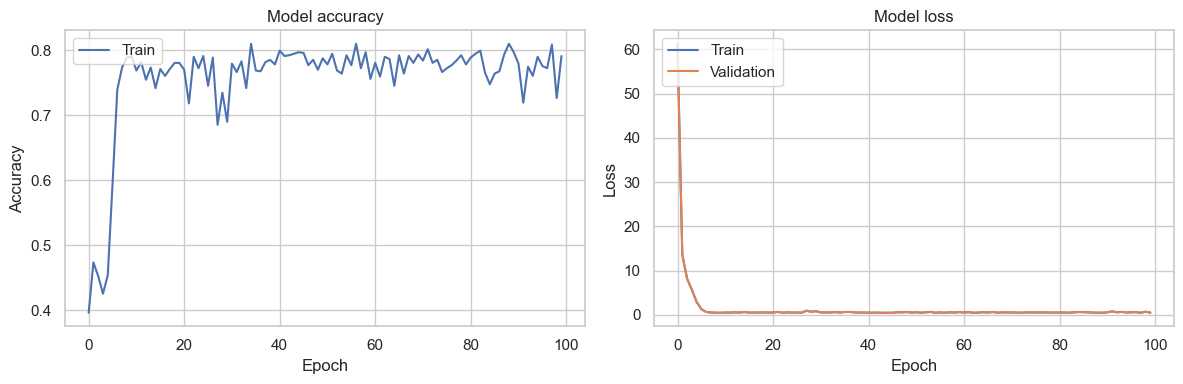

In [40]:
print(lstm_history.history.keys())

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plot_history function
plot_history(lstm_history)
plt.show()

### Predictions and Accuracy

In [91]:
predictions = lstm_model.predict(test_x)

predictions = [0 if i < .5 else 1 for i in predictions]
predictions = np.array(predictions)
print('Accuracy:',np.round((accuracy_score(test_y, predictions)*100),2),'%')

#print confusion matrix of results
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print('    0    1')

# print classification report
print("Classification Report:")
print(classification_report(test_y, predictions))


125/125 [==============================] - 0s 612us/step
Accuracy: 89.72 %
Confusion Matrix:
    0    1
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3874
           1       0.19      0.67      0.29       126

    accuracy                           0.90      4000
   macro avg       0.59      0.79      0.62      4000
weighted avg       0.96      0.90      0.92      4000



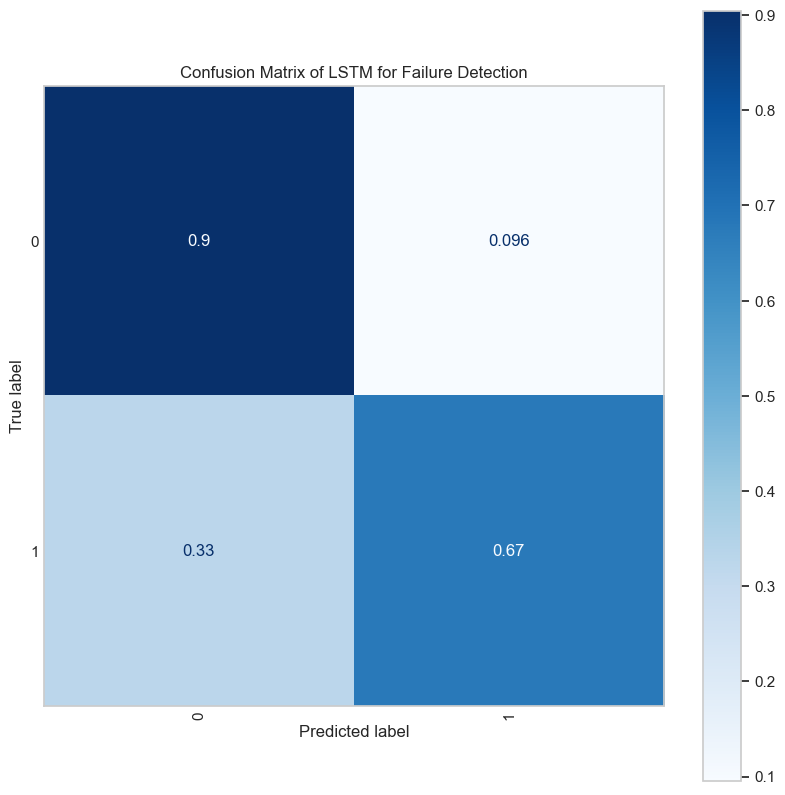

In [97]:
cm = confusion_matrix(test_y, predictions, labels=[0.0,1.0], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0','1'])


fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap = plt.cm.Blues)
plt.grid(False)
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.title('Confusion Matrix of LSTM for Failure Detection')
plt.show()

### Address Failure Type Imbalance

[]

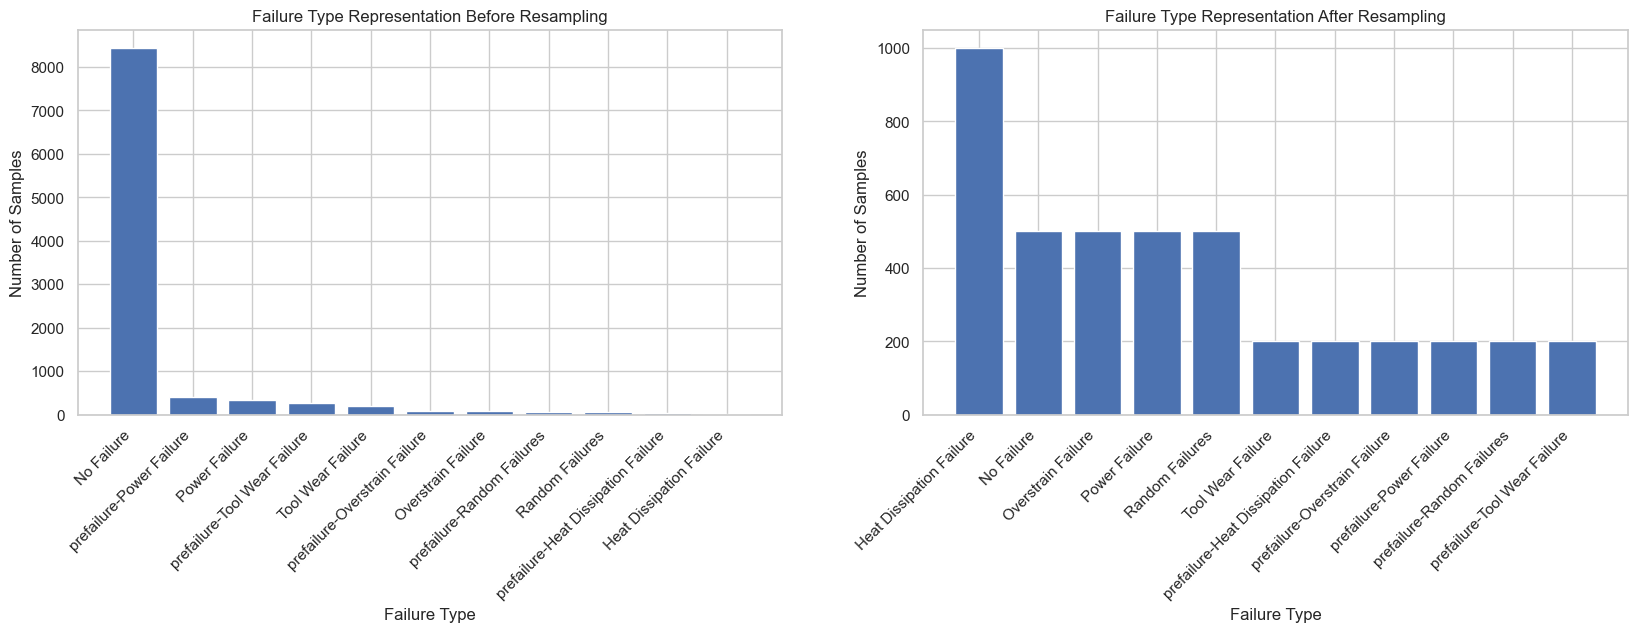

In [55]:
# Split Data
train_x_types, test_x_types, train_y_types, test_y_types = train_test_split(machining_failure_IVs, failure_types, test_size=0.4, random_state=32, shuffle=True)

# create 2 subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
ax1.bar(failure_types.unique(), failure_types.value_counts())
ax1.set_xlabel('Failure Type')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Failure Type Representation Before Resampling')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

undersampler_dict = {'No Failure': 1000,
                      'prefailure-Power Failure': 250,
                      'prefailure-Heat Dissipation Failure': 209,
                      'prefailure-Overstrain Failure': 158,
                      'prefailure-Tool Wear Failure' : 135,
                      'prefailure-Random Failures': 58,
                      'Power Failure': 56,
                      'Heat Dissipation Failure': 45,
                      'Overstrain Failure': 30,
                      'Tool Wear Failure': 29,
                      'Random Failures': 12}
oversampler_dict = {'No Failure': 1000,
                      'prefailure-Power Failure': 500,
                      'prefailure-Heat Dissipation Failure': 500,
                      'prefailure-Overstrain Failure': 500,
                      'prefailure-Tool Wear Failure' : 500,
                      'prefailure-Random Failures': 200,
                      'Power Failure': 200,
                      'Heat Dissipation Failure': 200,
                      'Overstrain Failure': 200,
                      'Tool Wear Failure': 200,
                      'Random Failures': 200}

undersampler = RandomUnderSampler(random_state = 32, replacement=False, sampling_strategy=undersampler_dict)
oversampler = RandomOverSampler(random_state=32, sampling_strategy=oversampler_dict)

train_x_types_under, train_y_types_under = undersampler.fit_resample(train_x_types, train_y_types)
train_x_types_over, train_y_types_over = oversampler.fit_resample(train_x_types_under, train_y_types_under)

ax2.bar(train_y_types_over.unique(), train_y_types_over.value_counts())
ax2.set_xlabel('Failure Type')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Failure Type Representation After Resampling')
plt.plot()

## Random Forest Modeling of Failure and Predicted Failure Types

In [58]:
# Create Random Forest Classifier Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=32)

# Fit to rebalanced training data
rf_model.fit(train_x_types_over, train_y_types_over)

# Create Predictions
rf_predictions = rf_model.predict(test_x_types)
#
#  Calculate and Display Accuracy Score
accuracy_score = accuracy_score(test_y_types, rf_predictions)
print('Accuracy Score:',np.round(accuracy_score*100,2),'%')

Accuracy Score: 78.3 %


### Model Evaluation

In [88]:
# Display Classification Report

print("Classification Report:")
print(classification_report(test_y_types, rf_predictions))


Classification Report:
                                     precision    recall  f1-score   support

           Heat Dissipation Failure       0.34      0.67      0.45        24
                         No Failure       0.95      0.83      0.88      3416
                 Overstrain Failure       0.40      0.55      0.46        22
                      Power Failure       0.55      0.85      0.67        27
                    Random Failures       0.17      0.25      0.20         4
                  Tool Wear Failure       0.08      0.17      0.11        12
prefailure-Heat Dissipation Failure       0.41      0.77      0.53       136
      prefailure-Overstrain Failure       0.26      0.69      0.38       102
           prefailure-Power Failure       0.22      0.19      0.20       165
         prefailure-Random Failures       0.19      0.27      0.23        22
       prefailure-Tool Wear Failure       0.26      0.63      0.37        70

                           accuracy                

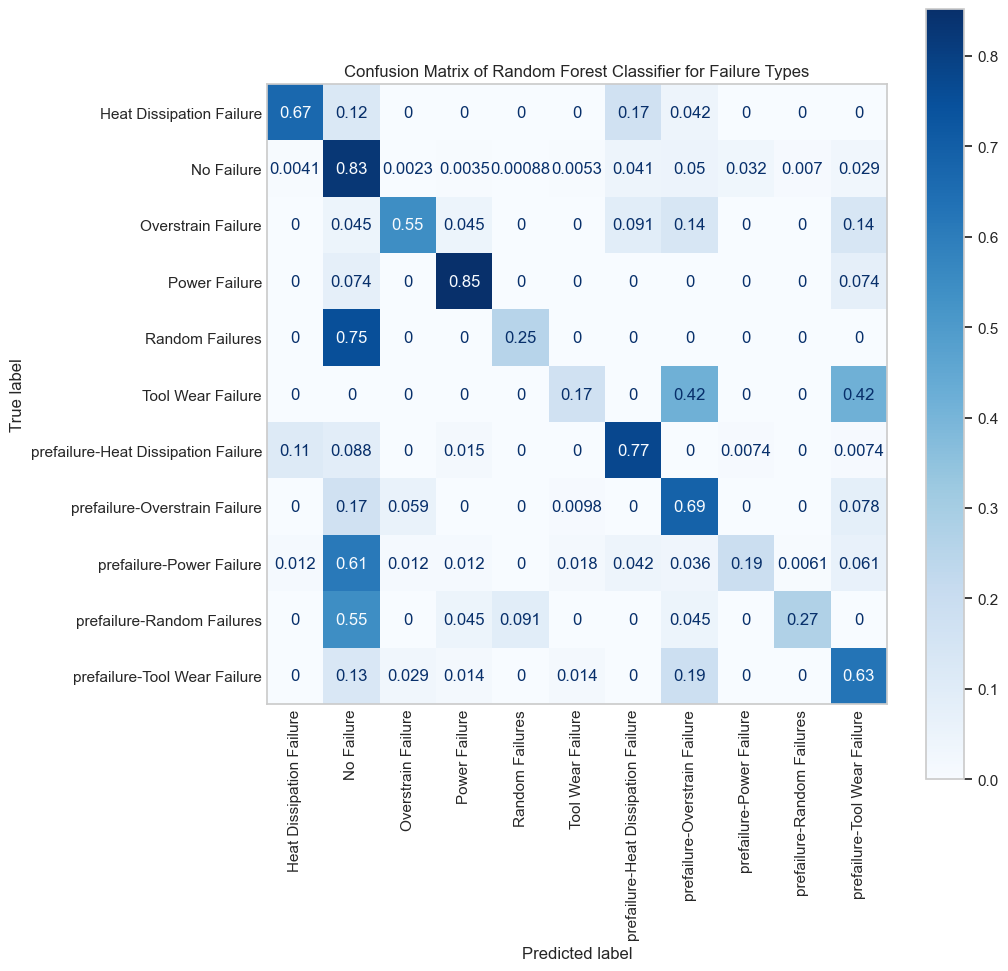

In [90]:
cm = confusion_matrix(test_y_types, rf_predictions, labels=rf_model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_)


fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap = plt.cm.Blues)
plt.grid(False)
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.title('Confusion Matrix of Random Forest Classifier for Failure Types')
plt.show()

## Evaluation


## Discussion and Conclusions